### Contents

[Imports](#Imports)

[bottom](#bottom)

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join as pjoin
import sys 
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent))
import json 
import orjson
import itertools 
from pprint import pprint
from datetime import datetime, date, timedelta
import requests 
import random
import time
from pprint import pprint
import json 

import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from fabulous import color as fb_color
from PIL import Image
from io import BytesIO
%matplotlib inline

from IPython.display import display, clear_output

In [3]:
ROOT_PATH = str(Path(os.getcwd()).parent)

In [4]:
from src.parse_utils import (
    get_catalog,
    find_card_url,
    get_images_urls_from_card_url
)
from src.utils import (
    get_uniq_items_with_images,
    show_items_images
)
from src.ml.utils import (
    VectorIndex,
    ImageEncoder
)
# image_encoder = ImageEncoder(model_str='google/vit-base-patch16-224-in21k')

/home/aiandrejcev/wb_parsing/wb3.11.4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
sns.set_style('whitegrid')

---

- facebook/sam-vit-huge 

    unsupervised image segmentation by masks

- google/owlvit-base-patch32

    zero-shot image segmentation by boxes

- timm/eva_large_patch14_196.in22k_ft_in22k_in1k

    Image encoder


In [6]:
catalog = get_catalog()
pprint(catalog)

[{'id': 1234, 'name': 'Сертификаты Wildberries', 'url': '/gift/certificates'},
 {'childs': [{'id': 8126,
              'name': 'Блузки и рубашки',
              'parent': 306,
              'query': 'cat=8126',
              'seo': 'Женские блузки и рубашки',
              'shard': 'bl_shirts',
              'url': '/catalog/zhenshchinam/odezhda/bluzki-i-rubashki'},
             {'id': 8127,
              'name': 'Брюки',
              'parent': 306,
              'query': 'cat=8127',
              'seo': 'Женские брюки',
              'shard': 'pants',
              'url': '/catalog/zhenshchinam/odezhda/bryuki-i-shorty'},
             {'id': 63010,
              'name': 'Верхняя одежда',
              'parent': 306,
              'query': 'cat=63010',
              'seo': 'Верхняя женская одежда',
              'shard': 'outwear1',
              'url': '/catalog/zhenshchinam/odezhda/verhnyaya-odezhda'},
             {'id': 8130,
              'name': 'Джемперы, водолазки и кардиганы',

In [7]:
all_urls = json.load(open(
    pjoin(ROOT_PATH, 'data/raw_data/all_urls_from_tmux.json')
))
print(f"{len(all_urls):,}")
print(f"{len([category_info for category_info in all_urls if category_info.get('products') is not None]):,}")

2,398
2,264


In [8]:
idxs = [idx for idx, category in enumerate(all_urls) if 'costumes' in str(category.get('shard'))]
idxs
[category for idx, category in enumerate(all_urls) if idx in idxs]

[{'category_id': 8134,
  'name': 'Костюмы',
  'shard': 'costumes',
  'query': 'cat=8134',
  'url': 'https://catalog.wb.ru/catalog/costumes/v2/catalog?ab_testing=false&appType=1&curr=rub&dest=-446116&sort=popular&spp=30&uclusters=0&cat=8134',
  'products': {'177703893': {'card_url': 'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/info/ru/card.json',
    'item_images_urls': ['https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/1.webp',
     'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/2.webp',
     'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/3.webp',
     'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/4.webp',
     'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/5.webp',
     'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/6.webp',
     'https://basket-12.wbbasket.ru/vol1777/part177703/177703893/images/big/7.webp',
     'https://basket-1

In [10]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

owl_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [20]:
url = (
    # "http://images.cocodataset.org/val2017/000000039769.jpg"
    "https://github.com/user-attachments/assets/3f794b46-e2ed-4de3-9e8e-5105cdbf76b7"
    # "https://github.com/user-attachments/assets/2c44b262-ed71-4dda-8e11-c9909b41bf29"
)
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

texts = [['pants', 'jeans', 'leggings', 'shorts', 'sweatpants', 'skirt', 'joggers', 'sweater', 't-shirt', 'sweatshirt', 'hoodie', 'dragon', 'dinosaur', 'helloween costume', 'dinasour costume',
'jacket', 'dress', 'romper', 'vest', 'cardigan', 'underwear', 'boxer', 'bra', 'pajamas', 'swimsuit',
'bralette', 'bikini', 'thong', 'slippers','sandal', 'boots', 'sneakers', 'shoes', 'cap', 'sunglasses', 'polo',
'jeggings', 'jogger', 'trouser', 'short', 'pajama', 'cami', 'tank', 'blouse', 'sandal', 'slipper', 'boots'
'skort', 'bracelet', 'earrings', 'necklace', 'beanie', 'hat', 'bikini top', 'bikini bottom', 'bag']]

with torch.no_grad():
    inputs = owl_processor(text=texts, images=image, return_tensors="pt")
    outputs = owl_model(**inputs)

    target_sizes = torch.Tensor([image.size[::-1]])
    results = owl_processor.post_process_object_detection(outputs=outputs, threshold=0.015, target_sizes=target_sizes)

text = texts[0]
boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

res = []
for box, score, label in zip(boxes, scores, labels):
    box = tuple([int(i) for i in box.tolist()])
    res.append((text[label], round(score.item(), 3), box))

res.sort(key=lambda x: x[1], reverse=True)
res

[('sweater', 0.063, (14, 39, 394, 484)),
 ('helloween costume', 0.061, (4, 0, 454, 898)),
 ('jeggings', 0.06, (88, 410, 455, 893)),
 ('helloween costume', 0.057, (2, 15, 436, 890)),
 ('helloween costume', 0.044, (2, 40, 451, 893)),
 ('slipper', 0.04, (421, 814, 454, 863)),
 ('slipper', 0.036, (389, 843, 451, 899)),
 ('cardigan', 0.03, (6, 56, 384, 630)),
 ('hoodie', 0.029, (3, 1, 375, 491)),
 ('jeggings', 0.028, (179, 429, 455, 892)),
 ('slipper', 0.028, (276, 778, 407, 900)),
 ('pajama', 0.021, (-2, 772, 232, 899)),
 ('beanie', 0.02, (133, 1, 308, 166)),
 ('sweater', 0.019, (18, 36, 383, 450)),
 ('sandal', 0.019, (378, 738, 455, 862)),
 ('sunglasses', 0.018, (158, 2, 284, 57)),
 ('jeggings', 0.017, (113, 464, 404, 899))]

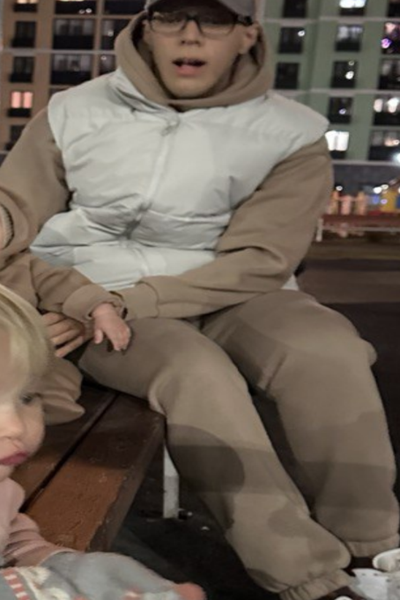

In [21]:
image.resize((400, 600))

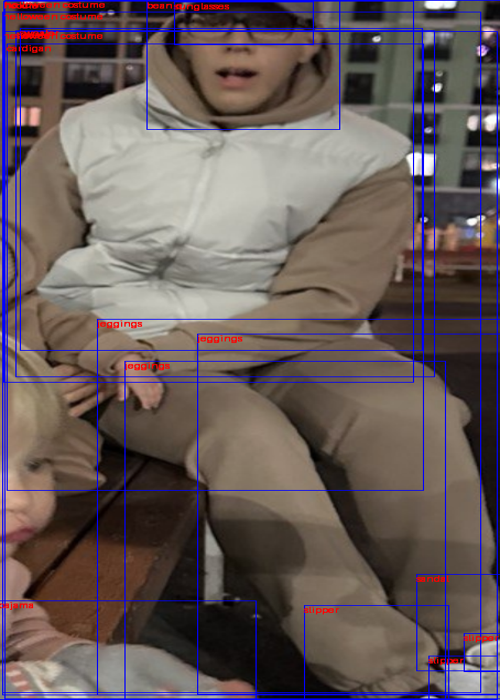

In [31]:
from PIL import Image, ImageDraw

draw = ImageDraw.Draw(image)

for type_, score, box in res:
    draw.rectangle(box, outline="blue", width=1)
    draw.text(box[:2], text=type_, fill='red', size=35)
    # Show the image with the drawn bounding box
image.resize((500, 700))

In [32]:
from transformers import pipeline


sam_mname = 'facebook/sam-vit-huge'
# sam_mname = 'facebook/sam-vit-base'
# sam_generator =  pipeline("mask-generation", model=sam_mname, device = 0, points_per_batch = 4)  # cuda
sam_generator =  pipeline("mask-generation", model=sam_mname, device = -1, points_per_batch = 4)  # nocuda

In [33]:
url = (
    # "http://images.cocodataset.org/val2017/000000039769.jpg"
    "https://github.com/user-attachments/assets/3f794b46-e2ed-4de3-9e8e-5105cdbf76b7"
    # "https://github.com/user-attachments/assets/2c44b262-ed71-4dda-8e11-c9909b41bf29"
)
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")


outputs = sam_generator(image, points_per_batch = 4)
res = sorted(outputs["masks"], key=lambda x: x.sum(), reverse=True)
res

### bottom